<a href="https://colab.research.google.com/github/joshtowell/deep-leakage-from-gradients/blob/main/deepLeakageFromGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Leakage from Gradients
*Modified by Joshua Towell (2128037) on 04/04/22*

**Original code reference:**\
Zhu, L. (2019) Deep Leakage From Gradients [software]. MIT HAN Lab.
Available from https://github.com/mit-han-lab/dlg [accessed 4 April 2022].

### Modifications:
*   Changes to configuration of DLG algorithm and datasets used
*   Fully commented and explained code



In [1]:
# Import necessary libraries and external modules
# PyTorch and Torch vision contain pre-defined functions and datasets relevant to ML

%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

# PyTorch version 1.10.0+cu111 and TorchVision version 0.11.1+cu111 used
print(torch.__version__, torchvision.__version__)

1.10.0+cu111 0.11.1+cu111


In [2]:
# Select predefined dataset (used CIFAR100 and CIFAR10)
# Dataset selected and transformation functions for pre-processing are defined here

dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

# Setting up environment for training and processing (CUDA GPU if available, otherwise CPU)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# Function for transforming image labels to binary arrays
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# Function for label smoothing label definitions
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch
Running on cpu


In [3]:
# Preparing neural network for model

# Defining weights and bias for model
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

# Defining LeNet neural network used for training
# Selected Sigmoid activation function
# Defining convolution layers in specified sequence
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instantiating LeNet model for given device, weights and criteria
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 76. 
Onehot label is 76.


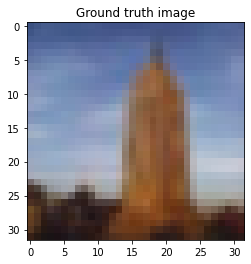

In [4]:
# Choosing participant (image) and applying pre-processing algorithms
# Creation of data and label to input for model

# Used images 45, 48 and 51 in both datasets
img_index = 45
# Transformed and rescaled images
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# Display ground truth training data and label
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# Compute original gradient using model
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())


# Exchange gradient with other training nodes
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

Dummy label is 27.


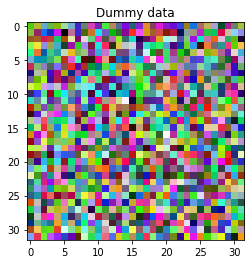

In [5]:
# Creating an intial random "dummy" image

# Generate randomised dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# Display dummy data and label
plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Iter.  Loss
0     194.5394 %
10     10.1553 %
20     2.9758 %
30     1.1031 %
40     0.4663 %
50     0.1421 %
60     0.0375 %
70     0.0111 %
80     0.0034 %
90     0.0012 %
100     0.0004 %
110     0.0002 %
120     0.0001 %
130     0.0000 %
140     0.0000 %
150     0.0000 %
160     0.0000 %
170     0.0000 %
180     0.0000 %
190     0.0000 %


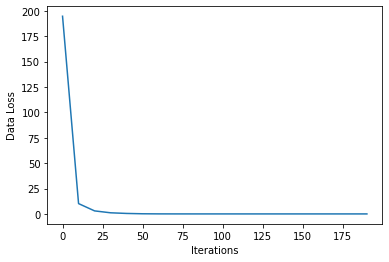

In [6]:
# Select optimiser and begin iterative attack on shared gradients to re-construct original image

# Choose the LBFGS optimisation algorithm
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

# Store iteration and data loss values
print("Iter.  Loss")
ax_iter = []
ax_loss = []

# Store each image iteration
history = []

# For each of the 200 iterations, predict new gradient for dummy data and apply the neural network to converge towards the original training data values
# Return the gradient distance ready for the next iteration
for iters in range(200):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    
    # Display progress every 10 iterations
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "   ", "%.4f" % current_loss.item(), "%")
        ax_iter.append(iters)
        ax_loss.append(current_loss)
    history.append(tt(dummy_data[0].cpu()))

# Display the data loss value per iteration on a graph
plt.plot(torch.tensor(ax_iter), torch.tensor(ax_loss))
plt.xlabel("Iterations")
plt.ylabel("Data Loss")
plt.show()

Dummy label is 76.


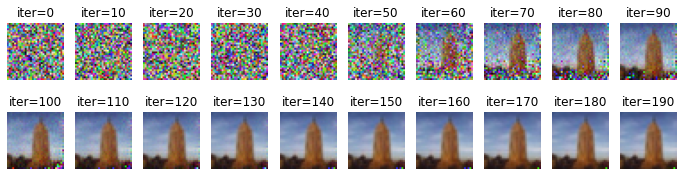

In [7]:
# Display the development of iterative image re-construction

# Plot generated image from every 10th iteration
plt.figure(figsize=(12, 3))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
  
# Display dummy label
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())